<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/Day3_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import requests
import io
import re
import time

In [56]:
# process file
def process_excel_file(url, year):
    print(url, year)
    try:
        response = requests.get(url)
        response.raise_for_status()
        excel_data = io.BytesIO(response.content)
        df = pd.read_excel(excel_data, sheet_name='Sign In Out Times Report')

        df = df.iloc[4:]
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header

        def rename_columns(df_format):
            count = 7
            old_col_name = None
            for col in df_format.columns[7:]:  # 'JAN 01' is the 8th column (index 7)
              if pd.isna(col):
                if old_col_name:
                  new_col_name = f"{old_col_name} - OUT"
                  df_format.columns.values[count] = new_col_name
              else:
                new_col_name = f"{col} - IN"
                old_col_name = col
                df_format.rename(columns={col: new_col_name}, inplace=True)

              count += 1
              if new_col_name == 'Dec 31 - OUT':
                break
            return df_format

        df = rename_columns(df)
        #print("Stage1")
        #display(df.head())
        #print(df.shape)

        df = df.dropna(subset=['Record ID'])
        df = df[~((df['Student Status'] != 'Active') & (df['Record ID'].isna()))]
        #print("Stage2")
        #display(df.head())
        #print(df.shape)

        columns_to_drop = ['First Name', 'Last Name', 'External Student ID', 'Student Status', 'Tags']
        df = df.drop(columns=columns_to_drop, errors='ignore')
        #print("Stage3")
        #display(df.head())
        #print(df.shape)

        def remove_rows_with_no_data(df):
            rows_to_drop = []
            for index, row in df.iterrows():
                if pd.isna(row.iloc[2:]).all():
                    rows_to_drop.append(index)
            return df.drop(rows_to_drop)

        df = remove_rows_with_no_data(df)
        #print("Stage4")
        #display(df.head())
        #print(df.shape)

        def reshape_data(df):
            date_cols = df.columns[2:]
            reshaped_data = []
            for index, row in df.iterrows():
                record_id = row['Record ID']
                room = row['Room']
                for date_col in date_cols:
                    in_time = row[date_col]
                    col_index = date_cols.get_loc(date_col)
                    if 'IN' in date_col and col_index < len(date_cols) -1:
                        out_time_col = date_cols[col_index + 1]
                        out_time = row[out_time_col]
                        reshaped_data.append([record_id, room, date_col, in_time, out_time])
            return pd.DataFrame(reshaped_data, columns=['Record ID', 'Room', 'Date', 'IN', 'OUT'])

        df = reshape_data(df)
        #print("Stage5")
        #display(df.head())
        #print(df.shape)

        def extract_time_new(time_str):
          if pd.isna(time_str):
              return ""
          match = re.search(r'(\d+:\d+\s*[APap][Mm])', str(time_str))
          if match:  # Check if a match was found
            return match.group(1)  # Access group(1) only if match is not None
          else:
            return ""

        def extract_time(time_str):
            if pd.isna(time_str):
                return ""
            match = re.search(r'(\d+:\d+\s*[APap][Mm])', str(time_str))
            return match.group(1) if match else ""

        df['IN'] = df['IN'].apply(extract_time)
        print('lm Here')
        df['OUT'] = df['OUT'].apply(extract_time)

        df = df.dropna(subset=['IN', 'OUT'], how='all')
        df = df[~((df['IN'] == "") & (df['OUT'] == ""))]

        df['Date'] = df['Date'].str.replace(' - IN', f" {year}")
        #print("Stage6")
        #display(df.head())
        #df.shape

        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the file: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [68]:
# Example usage
urls = [
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202022%20Student%20Sign%20In%20and%20Out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202023%20Student%20Sign%20In%20and%20Out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202024%20Student%20Sign%20In%20and%20Out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202025%2001012025-02282025%20Student%20Sign%20In%20and%20Out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202022%20Student%20Sign%20in%20and%20out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202023%20Student%20Sign%20in%20and%20out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202024%20Student%20Sign%20in%20and%20out.xlsx?raw=true',
    'https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202025%2001012025-02282025%20Student%20Sign%20in%20and%20out.xlsx?raw=true'
    ]
years = [
    '2022',
    '2023',
    '2024',
    '2025',
    '2022',
    '2023',
    '2024',
    '2025'
    ]

all_dfs = all_dfs = []
for i, url in enumerate(urls):
    print(url, years[i])
    time.sleep(20)
    result_df = process_excel_file(url, years[i])
    if result_df is not None:
        print(f"Stage7 -{years[i]}")
        display(result_df.head())
        result_df.shape
        all_dfs.append(result_df)

final_df = pd.concat(all_dfs, ignore_index=True)  # Concatenate all DataFrames
display(final_df.head())  # Display the head of the final DataFrame
print(final_df.shape)      # Print the shape of the final DataFrame


https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202022%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2022
https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202022%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2022
lm Here
Stage7 -2022


,Record ID,Room,Date,IN,OUT
2,KL100213,Pre-K1,Jan 03 2022,9:04 AM,5:07 PM
3,KL100213,Pre-K1,Jan 04 2022,8:49 AM,5:15 PM
4,KL100213,Pre-K1,Jan 05 2022,9:04 AM,5:30 PM
5,KL100213,Pre-K1,Jan 06 2022,8:42 AM,5:14 PM
6,KL100213,Pre-K1,Jan 07 2022,8:46 AM,4:57 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202023%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2023
https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202023%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2023
lm Here
Stage7 -2023


,Record ID,Room,Date,IN,OUT
2,KL100213,Pre-K1,Jan 03 2023,9:36 AM,3:24 PM
3,KL100213,Pre-K1,Jan 04 2023,8:55 AM,5:06 PM
4,KL100213,Pre-K1,Jan 05 2023,8:45 AM,5:24 PM
5,KL100213,Pre-K1,Jan 06 2023,8:47 AM,5:20 PM
8,KL100213,Pre-K1,Jan 09 2023,8:45 AM,4:49 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202024%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2024
https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202024%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2024
lm Here
Stage7 -2024


,Record ID,Room,Date,IN,OUT
288,KL100349,Pennie Preschool 1,Oct 15 2024,9:29 AM,4:44 PM
289,KL100349,Pennie Preschool 1,Oct 16 2024,10:39 AM,5:27 PM
290,KL100349,Pennie Preschool 1,Oct 17 2024,9:47 AM,5:15 PM
291,KL100349,Pennie Preschool 1,Oct 18 2024,10:01 AM,3:22 PM
294,KL100349,Pennie Preschool 1,Oct 21 2024,10:14 AM,5:36 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202025%2001012025-02282025%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2025
https://github.com/newton143/Business_Forecasting_Project/blob/main/ECEC%202025%2001012025-02282025%20Student%20Sign%20In%20and%20Out.xlsx?raw=true 2025
lm Here
Stage7 -2025


,Record ID,Room,Date,IN,OUT
1,KL100349,Pennie Preschool 1,Jan 02 2025,8:40 AM,5:11 PM
2,KL100349,Pennie Preschool 1,Jan 03 2025,8:26 AM,4:36 PM
5,KL100349,Pennie Preschool 1,Jan 06 2025,8:08 AM,5:33 PM
6,KL100349,Pennie Preschool 1,Jan 07 2025,9:11 AM,4:45 PM
7,KL100349,Pennie Preschool 1,Jan 08 2025,8:52 AM,4:55 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202022%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2022
https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202022%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2022
lm Here
Stage7 -2022


,Record ID,Room,Date,IN,OUT
9,KL100233,Wild Things,Jan 10 2022,7:48 AM,3:52 PM
10,KL100233,Wild Things,Jan 11 2022,7:55 AM,4:05 PM
11,KL100233,Wild Things,Jan 12 2022,8:02 AM,4:08 PM
12,KL100233,Wild Things,Jan 13 2022,8:14 AM,4:05 PM
13,KL100233,Wild Things,Jan 14 2022,7:57 AM,11:53 AM


https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202023%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2023
https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202023%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2023
lm Here
Stage7 -2023


,Record ID,Room,Date,IN,OUT
234,KL100367,Dinosaur Stomp,Aug 23 2023,8:40 AM,12:15 PM
235,KL100367,Dinosaur Stomp,Aug 24 2023,8:23 AM,1:35 PM
236,KL100367,Dinosaur Stomp,Aug 25 2023,8:50 AM,1:38 PM
239,KL100367,Dinosaur Stomp,Aug 28 2023,9:23 AM,4:42 PM
240,KL100367,Dinosaur Stomp,Aug 29 2023,8:14 AM,3:16 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202024%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2024
https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202024%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2024
lm Here
Stage7 -2024


,Record ID,Room,Date,IN,OUT
10,KL100393,Llamas Llamas,Jan 11 2024,10:26 AM,4:48 PM
15,KL100393,Llamas Llamas,Jan 16 2024,10:19 AM,
23,KL100393,Llamas Llamas,Jan 24 2024,10:00 AM,4:00 PM
24,KL100393,Llamas Llamas,Jan 25 2024,10:00 AM,5:54 PM
25,KL100393,Llamas Llamas,Jan 26 2024,9:16 AM,5:37 PM


https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202025%2001012025-02282025%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2025
https://github.com/newton143/Business_Forecasting_Project/blob/main/Spellman%20CDC%202025%2001012025-02282025%20Student%20Sign%20in%20and%20out.xlsx?raw=true 2025
lm Here
Stage7 -2025


,Record ID,Room,Date,IN,OUT
5,KL100393,Llamas Llamas,Jan 06 2025,9:20 AM,4:45 PM
6,KL100393,Llamas Llamas,Jan 07 2025,10:16 AM,4:29 PM
7,KL100393,Llamas Llamas,Jan 08 2025,9:52 AM,4:55 PM
8,KL100393,Llamas Llamas,Jan 09 2025,10:20 AM,4:30 PM
9,KL100393,Llamas Llamas,Jan 10 2025,9:05 AM,4:21 PM


,Record ID,Room,Date,IN,OUT
0,KL100213,Pre-K1,Jan 03 2022,9:04 AM,5:07 PM
1,KL100213,Pre-K1,Jan 04 2022,8:49 AM,5:15 PM
2,KL100213,Pre-K1,Jan 05 2022,9:04 AM,5:30 PM
3,KL100213,Pre-K1,Jan 06 2022,8:42 AM,5:14 PM
4,KL100213,Pre-K1,Jan 07 2022,8:46 AM,4:57 PM


(131911, 5)


In [69]:
final_df.shape

(131911, 5)

In [70]:
final_df['Room'].unique()

array(['Pre-K1', 'Henry Toddlers', 'Pre-K2', 'Pennie Preschool 1',
       'Grampy Tom Preschool', 'Grampy Tom Toddlers', 'Henry Multi-Age',
       'Grampy Tom Multi-Age', 'Pennie Toddlers', 'Henry Infants', 'Camp',
       'Pennie Infants', 'Wild Things', 'Dinosaur Stomp', 'Monkeys',
       'Pandas', 'Llamas Llamas', 'Rainbow Fish', 'House Pooh', 'Rabbits',
       'Hungry Caterpillars', 'Goodnight Moon'], dtype=object)

In [72]:
# prompt: Add a column 'location' next to 'Room', based on following mapping if the room is in this list (Pennie Preschool 1
# Henry Multi-Age
# Grampy Tom Multi-Age
# Henry Infants
# Pennie Infants
# Pre-K1
# Pre-K2
# Pennie Toddlers
# Henry Toddlers
# Grampy Tom Toddlers
# Grampy Tom Preschool
# Camp) then “ECEC”
# else: “Spellman”

def add_location_column(df):
    ecec_rooms = ['Pennie Preschool 1', 'Henry Multi-Age', 'Grampy Tom Multi-Age',
                  'Henry Infants', 'Pennie Infants', 'Pre-K1', 'Pre-K2',
                  'Pennie Toddlers', 'Henry Toddlers', 'Grampy Tom Toddlers',
                  'Grampy Tom Preschool', 'Camp']

    df['location'] = df['Room'].apply(lambda x: 'ECEC' if x in ecec_rooms else 'Spellman')
    return df

# Assuming 'final_df' is your DataFrame from the previous code
final_df = add_location_column(final_df)
display(final_df.head())  # Display the head of the final DataFrame
print(final_df.shape)      # Print the shape of the final DataFrame


,Record ID,Room,Date,IN,OUT,location
131906,KL100413,Wild Things,Feb 19 2025,9:05 AM,3:21 PM,Spellman
131907,KL100413,Wild Things,Feb 24 2025,8:53 AM,3:48 PM,Spellman
131908,KL100413,Wild Things,Feb 27 2025,8:34 AM,3:06 PM,Spellman
131909,KL100413,Wild Things,Feb 28 2025,8:40 AM,3:26 PM,Spellman
131910,KL100413,Wild Things,Jan 07 2025,3:56 PM,3:56 PM,Spellman


(131911, 6)


In [73]:
# prompt: add a column 'AgeGroup' based on 'Room' mapping given below room_mapping = {
#     'Good Night Moon': 'Infant',
#     'Goodnight Moon': 'Infant',
#     'Panda Bear': 'Toddler',
#     'House of Pooh': 'Infant',
#     'Llama Llama': 'Multi-Age',
#     'Caterpillars': 'Multi-Age',
#     'Rabbits': 'Toddler',
#     'Wild Things': 'Preschool',
#     'Monkeys': 'Toddler',
#     'Rainbow Fish': 'Preschool',
#     'Dinosaurs': 'Pre-K',
#     'Pre-K1': 'Pre-K',
#     'Pre-K2': 'Pre-K',
#     'Henry Toddlers': 'Toddler',
#     'Pennie Preschool 1': 'Preschool',
#     'Grampy Tom Preschool': 'Preschool',
#     'Grampy Tom Toddlers': 'Toddler',
#     'Henry Multi-Age': 'Multi-Age',
#     'Grampy Tom Multi-Age': 'Multi-Age',
#     'Pennie Toddlers': 'Toddler',
#     'Henry Infants': 'Infant',
#     'Camp': 'Multi-Age',
#     'Pennie Infants': 'Infant',
#     'Dinosaur Stomp': 'Pre-K',
#     'Pandas': 'Toddler',
#     'Llamas Llamas': 'Multi-Age',
#     'House Pooh': 'Infant',
#     'Hungry Caterpillars': 'Multi-Age'
# }

room_mapping = {
    'Good Night Moon': 'Infant',
    'Goodnight Moon': 'Infant',
    'Panda Bear': 'Toddler',
    'House of Pooh': 'Infant',
    'Llama Llama': 'Multi-Age',
    'Caterpillars': 'Multi-Age',
    'Rabbits': 'Toddler',
    'Wild Things': 'Preschool',
    'Monkeys': 'Toddler',
    'Rainbow Fish': 'Preschool',
    'Dinosaurs': 'Pre-K',
    'Pre-K1': 'Pre-K',
    'Pre-K2': 'Pre-K',
    'Henry Toddlers': 'Toddler',
    'Pennie Preschool 1': 'Preschool',
    'Grampy Tom Preschool': 'Preschool',
    'Grampy Tom Toddlers': 'Toddler',
    'Henry Multi-Age': 'Multi-Age',
    'Grampy Tom Multi-Age': 'Multi-Age',
    'Pennie Toddlers': 'Toddler',
    'Henry Infants': 'Infant',
    'Camp': 'Multi-Age',
    'Pennie Infants': 'Infant',
    'Dinosaur Stomp': 'Pre-K',
    'Pandas': 'Toddler',
    'Llamas Llamas': 'Multi-Age',
    'House Pooh': 'Infant',
    'Hungry Caterpillars': 'Multi-Age'
}

final_df['AgeGroup'] = final_df['Room'].map(room_mapping)
display(final_df.head())  # Display the head of the final DataFrame
print(final_df.shape)      # Print the shape of the final DataFrame

,Record ID,Room,Date,IN,OUT,location,AgeGroup
0,KL100213,Pre-K1,Jan 03 2022,9:04 AM,5:07 PM,ECEC,Pre-K
1,KL100213,Pre-K1,Jan 04 2022,8:49 AM,5:15 PM,ECEC,Pre-K
2,KL100213,Pre-K1,Jan 05 2022,9:04 AM,5:30 PM,ECEC,Pre-K
3,KL100213,Pre-K1,Jan 06 2022,8:42 AM,5:14 PM,ECEC,Pre-K
4,KL100213,Pre-K1,Jan 07 2022,8:46 AM,4:57 PM,ECEC,Pre-K


(131911, 7)


In [78]:
!pip install numpy<3.0.0
!pip install pygam


/bin/bash: line 1: 3.0.0: No such file or directory


In [79]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s
import plotly.graph_objects as go

# Assuming final_df is already created and processed as in your provided code

# Convert 'Date' column to datetime objects
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Set 'Date' as index
final_df.set_index('Date', inplace=True)

# Create a time series with 30-minute frequency
final_df = final_df.resample('30min').asfreq().fillna(0)  # Fill NaN with 0 students

# Feature engineering
final_df['year'] = final_df.index.year
final_df['month'] = final_df.index.month
final_df['day'] = final_df.index.day
final_df['hour'] = final_df.index.hour
final_df['minute'] = final_df.index.minute

# Example forecast for the week of March 1 to March 7, 2025
# Specify the start and end date for your forecast period.
start_date = pd.to_datetime('2025-03-01')
end_date = pd.to_datetime('2025-03-07')

forecast_data = []

for room in final_df['Room'].unique():
    for location in final_df['location'].unique():
        # Filter data
        room_location_data = final_df[(final_df['Room'] == room) & (final_df['location'] == location)]

        # Create new index for 30-minute intervals
        idx = pd.date_range(start_date, end_date, freq='30min')

        # Set exog variables
        exog_vars = ['year', 'month', 'day', 'hour', 'minute']
        X_train = room_location_data[exog_vars].astype(np.float64).values
        y_train = room_location_data['Record ID'].astype(np.float64).values

        #Train the model (if data is available)
        if len(y_train) > 0 :
            model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)) # Consider minutes as well
            model.fit(X_train, y_train)

            # Create future dataframe
            future_df = pd.DataFrame(index=idx)
            future_df['year'] = future_df.index.year
            future_df['month'] = future_df.index.month
            future_df['day'] = future_df.index.day
            future_df['hour'] = future_df.index.hour
            future_df['minute'] = future_df.index.minute

            X_forecast = future_df[exog_vars].astype(np.float64).values
            forecast = model.predict(X_forecast)

            # Add results to the forecast_data list
            for i in range(len(idx)):
                forecast_data.append({
                    'Date': idx[i],
                    'Room': room,
                    'Location': location,
                    'Forecast': int(np.round(forecast[i]))
                })
        else: # if data is not available for a specific room/location
             for date in idx:
                 forecast_data.append({
                    'Date': date,
                    'Room': room,
                    'Location': location,
                    'Forecast': 0  # Default to 0 if no training data exists
                })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_data)
print(forecast_df.head())
# Now you have the forecasts in forecast_df. You can further process and analyze it.


ValueError: cannot reindex on an axis with duplicate labels

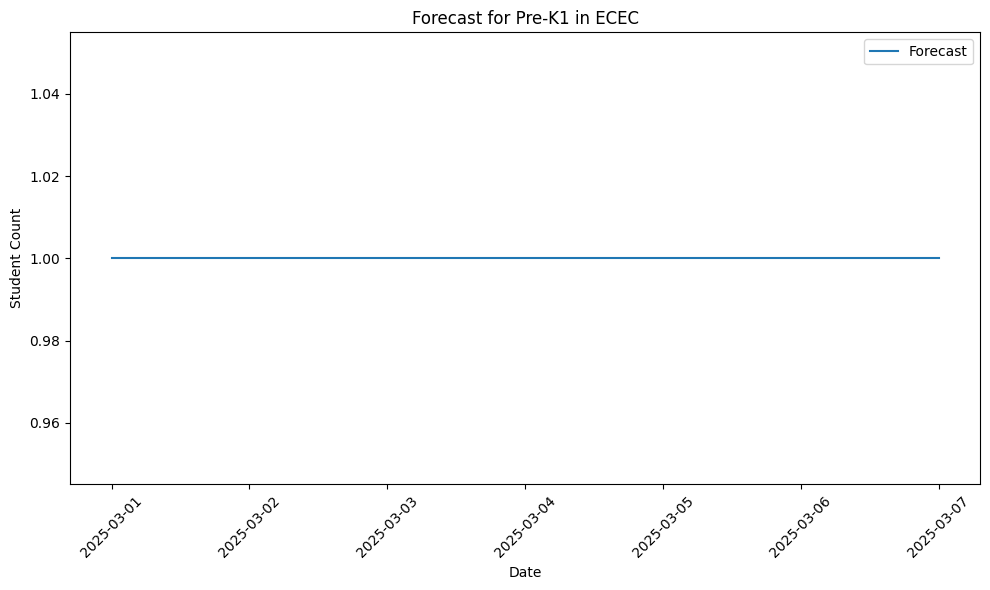

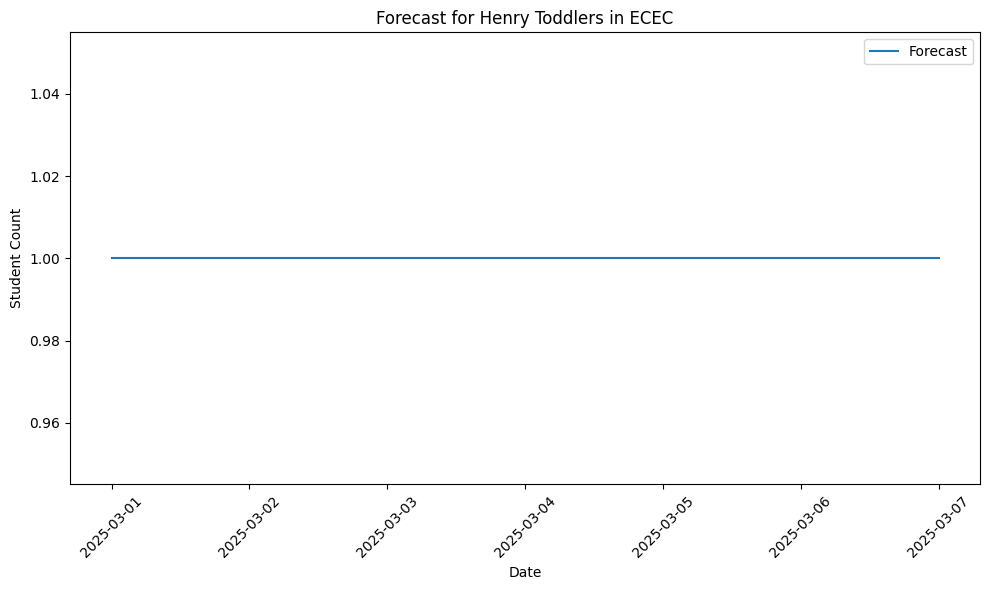

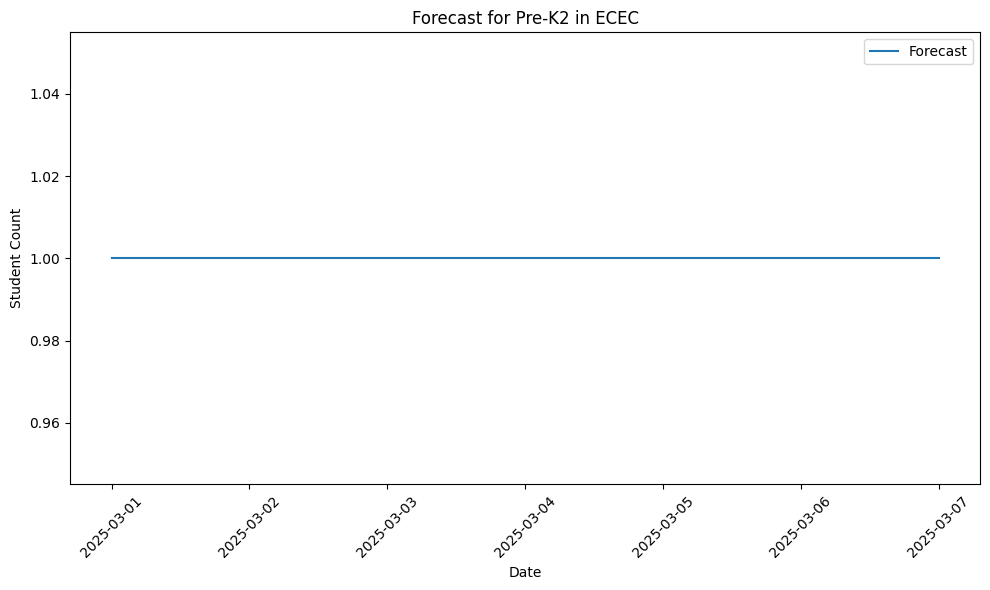

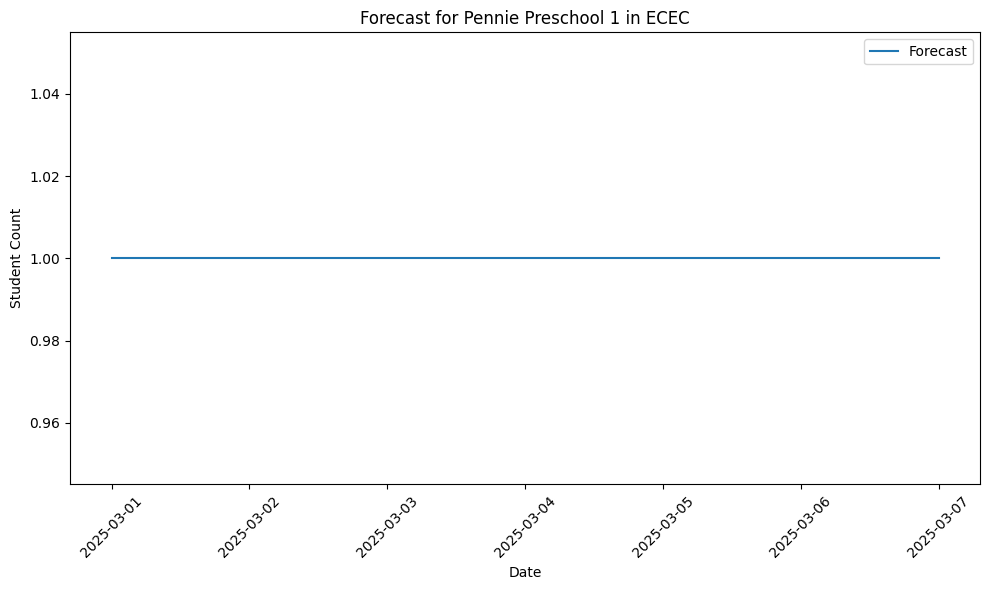

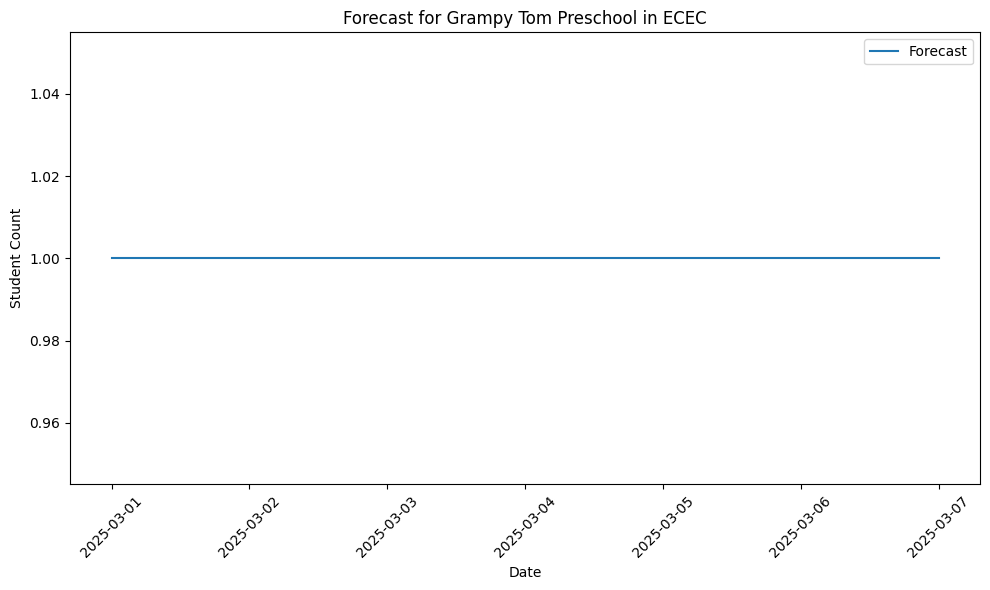

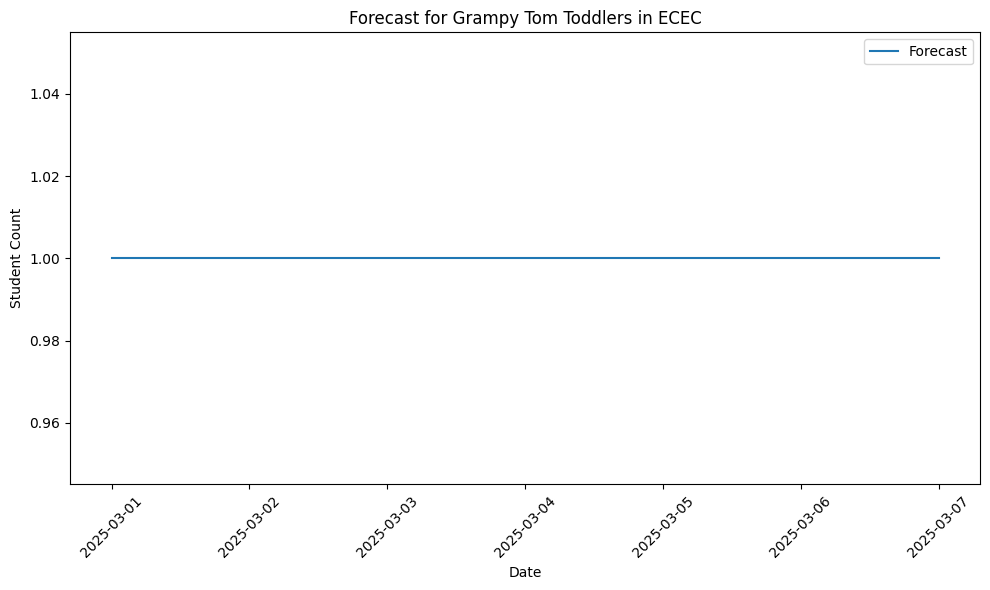

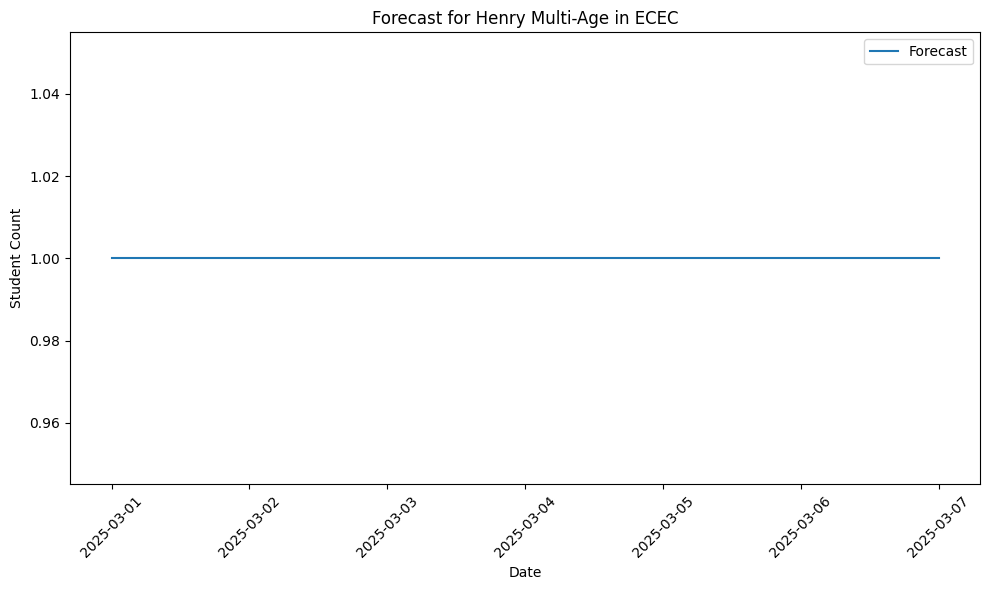

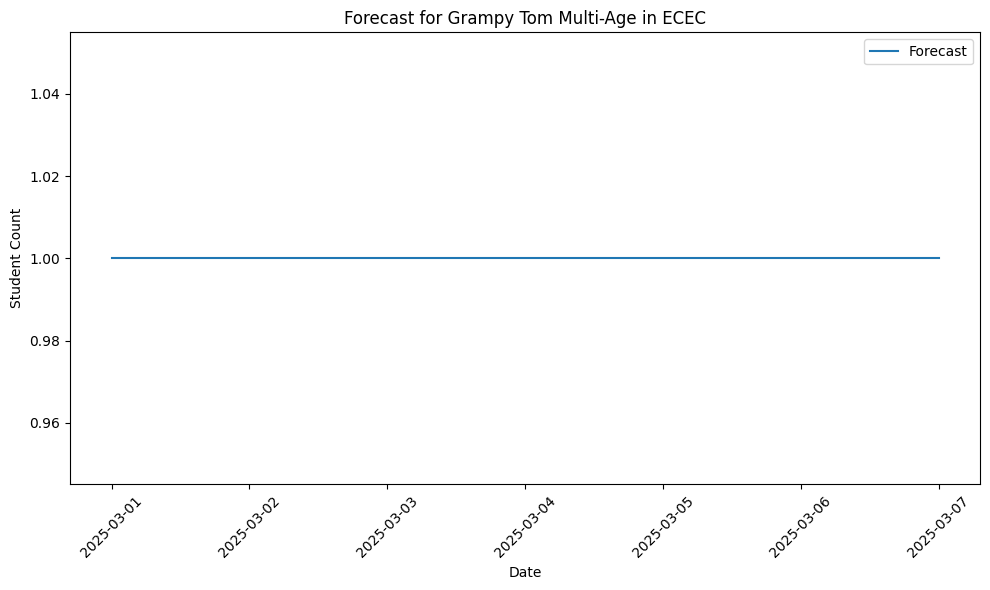

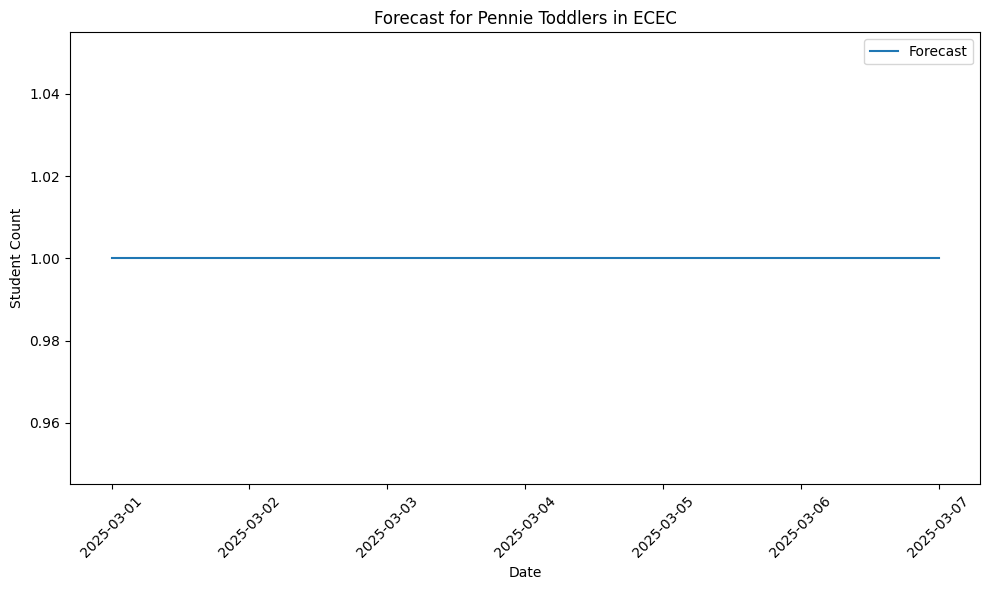

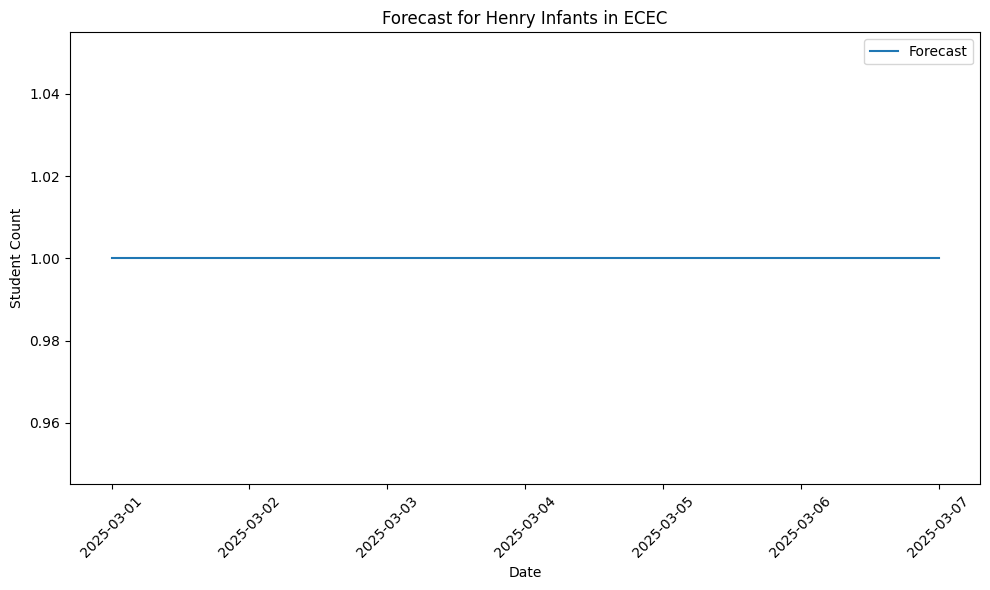

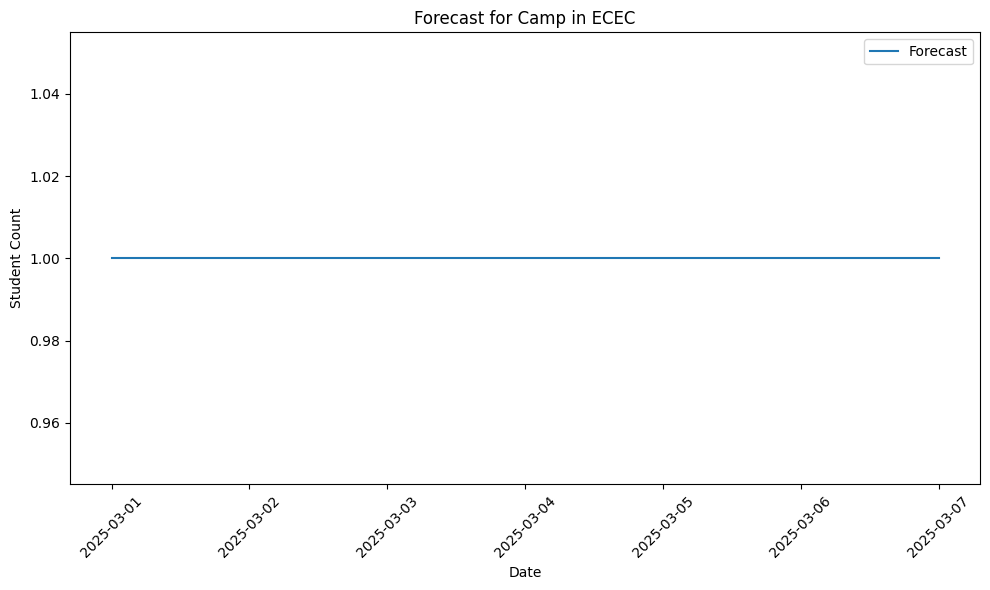

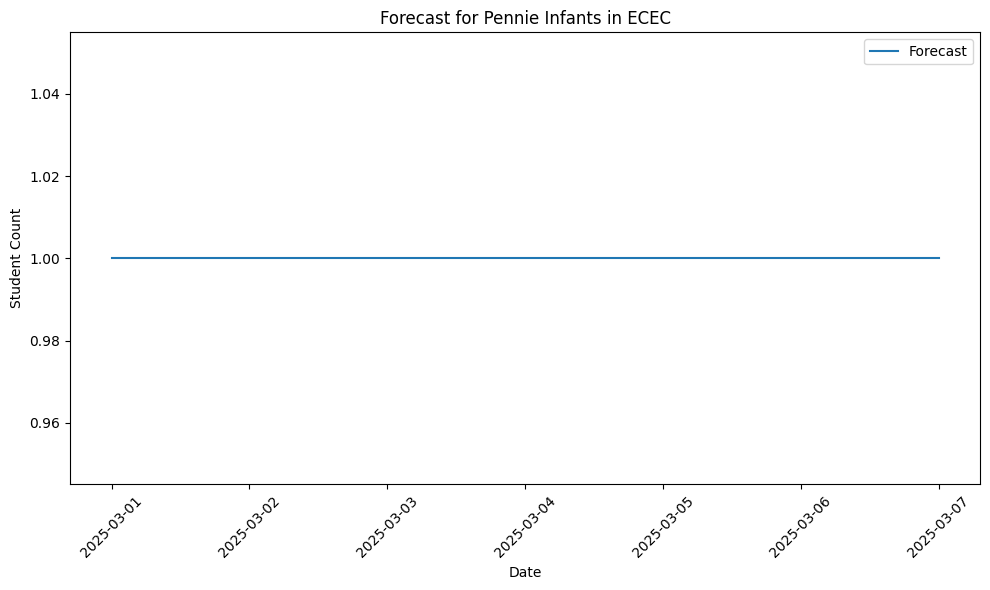

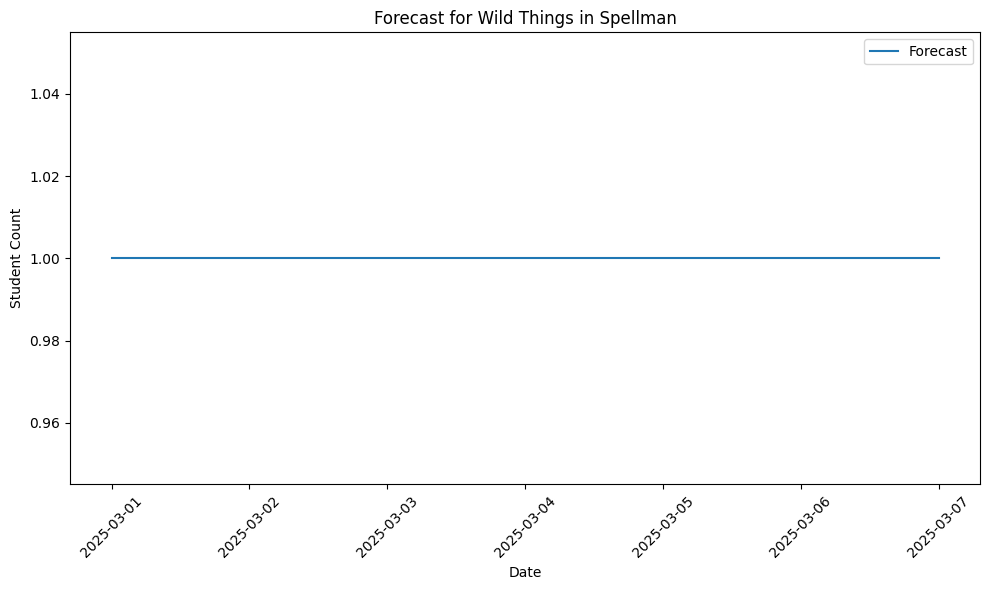

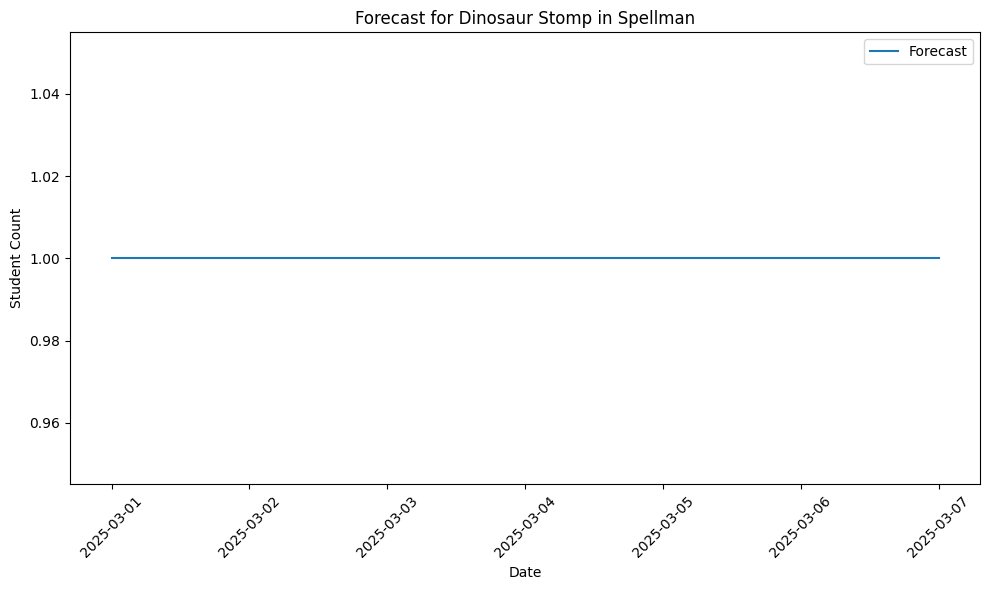

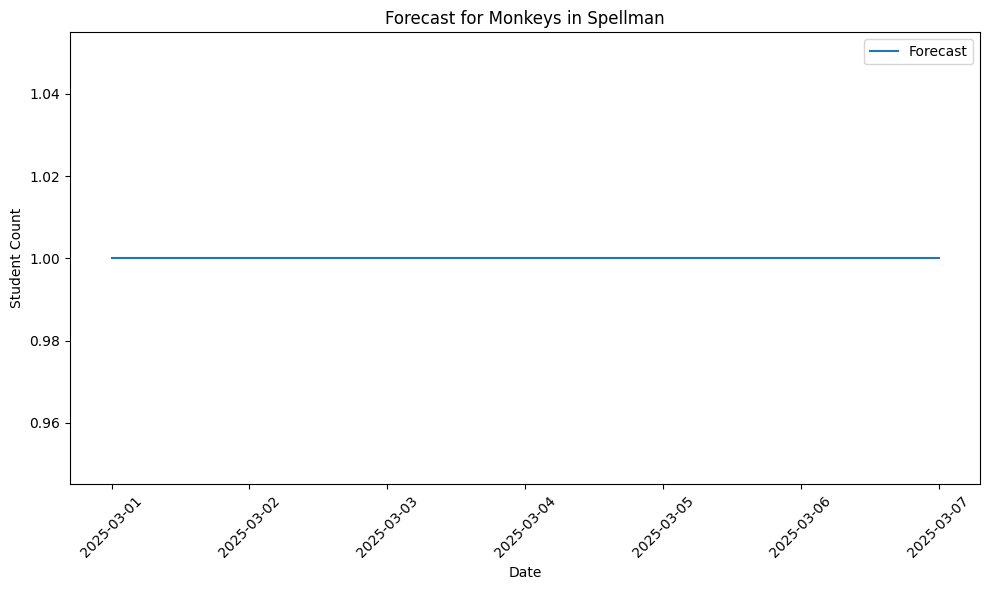

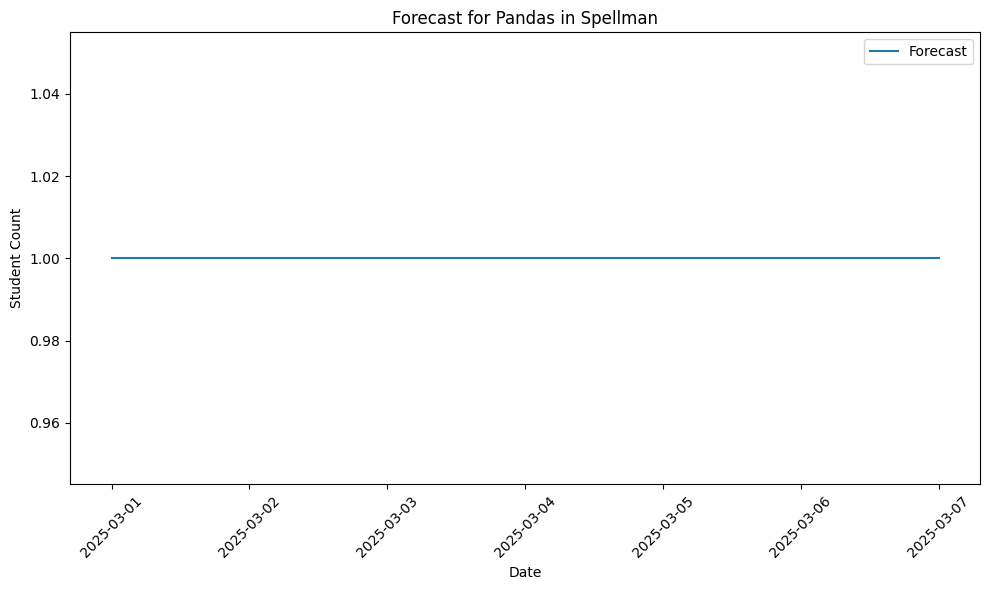

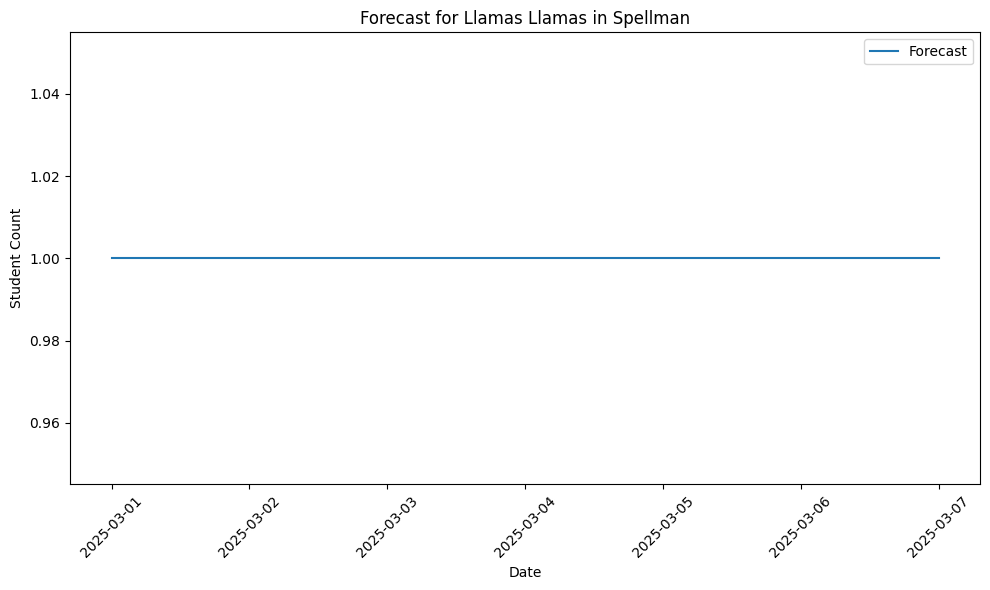

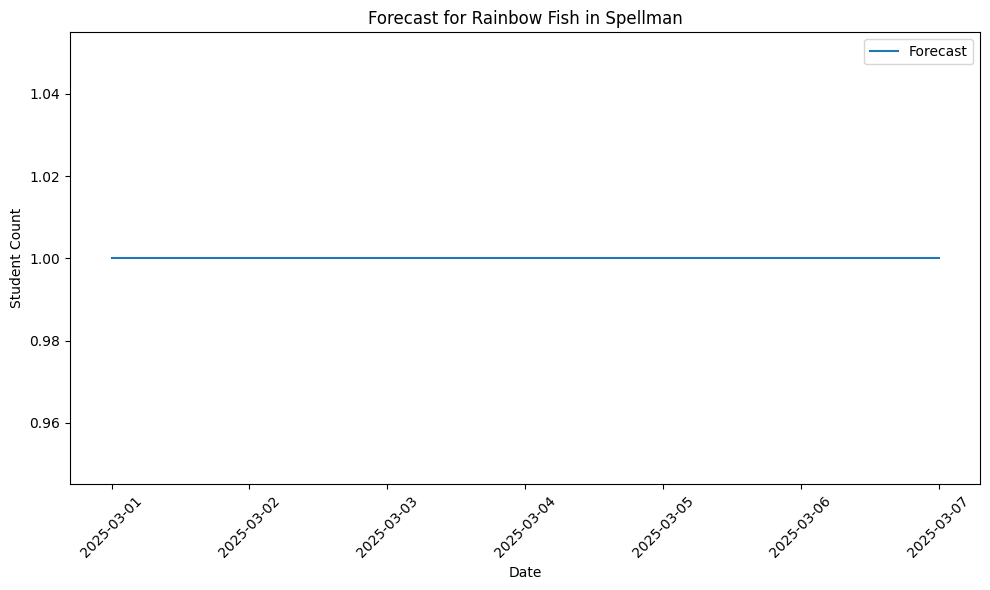

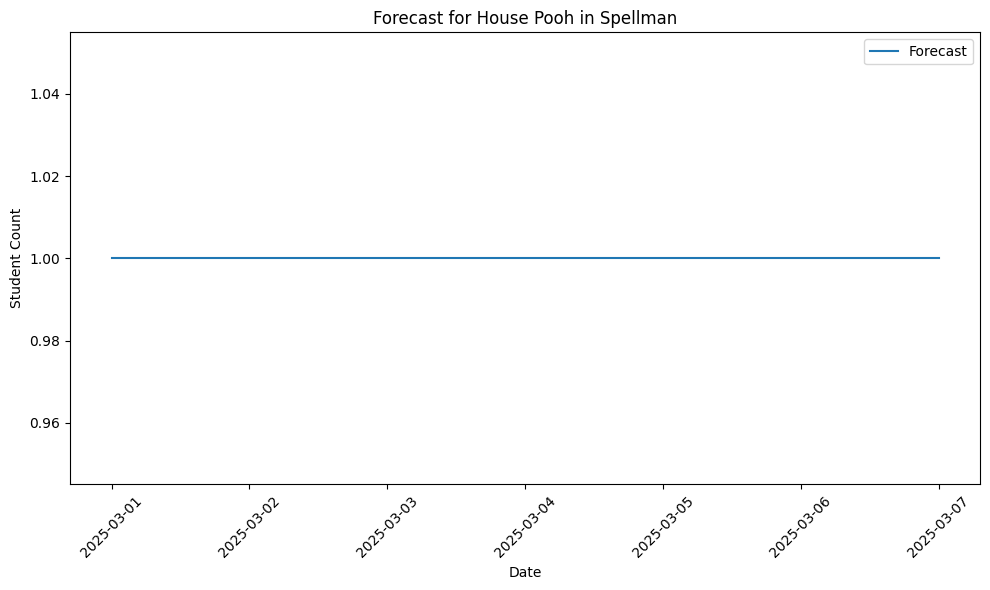

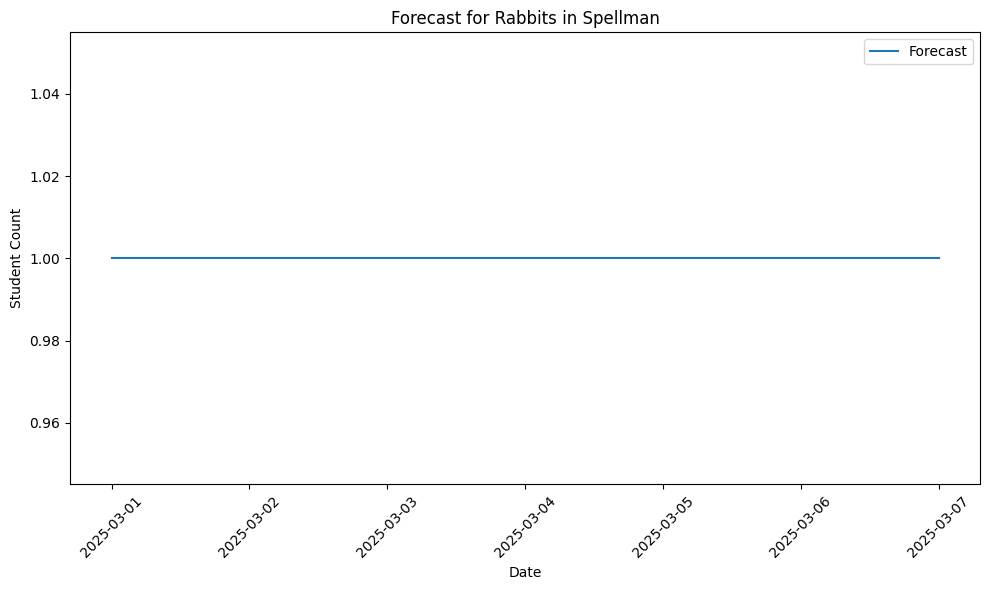

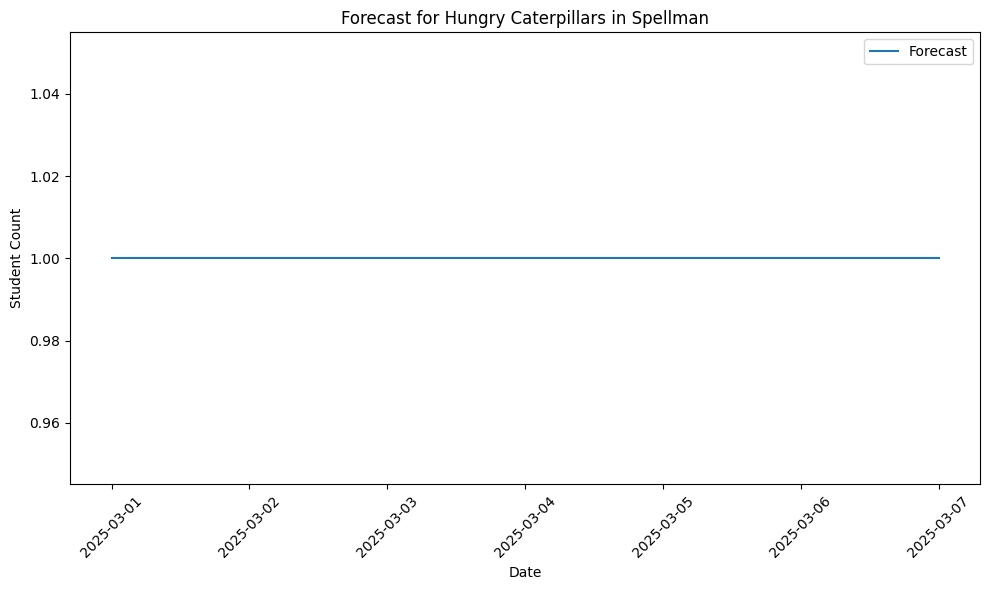

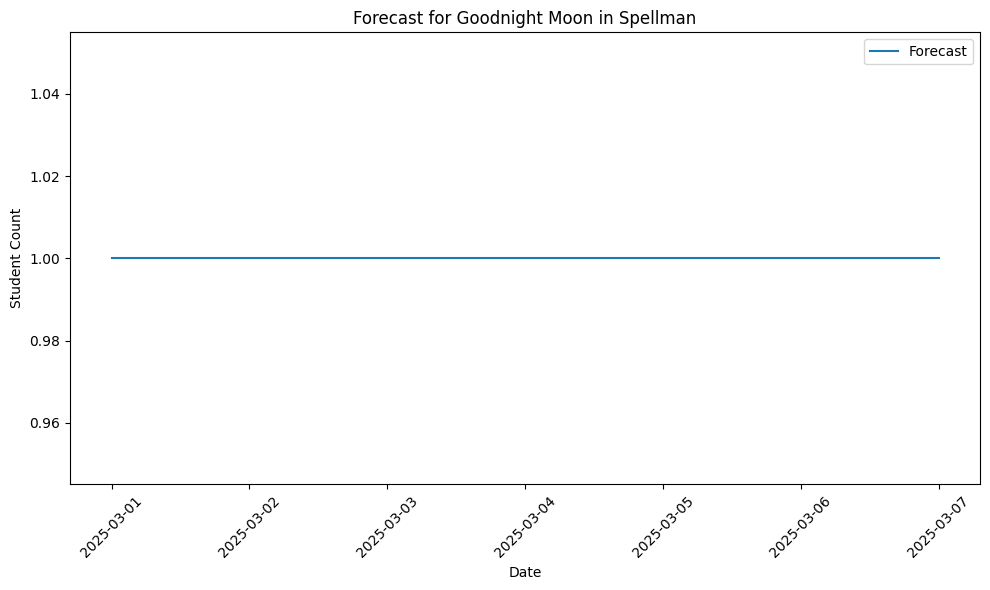

In [75]:
# prompt: visualize the forecast

import matplotlib.pyplot as plt

# Assuming forecast_data is already populated from the previous code

for (room, location), forecast_df in forecast_data.items():
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Student Count')
    plt.title(f'Forecast for {room} in {location}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()
